In [56]:
#导入数据
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
%matplotlib inline
plt.style.use('fivethirtyeight')

In [57]:
#读取数据 
data=pd.read_excel('data.xlsx') 
data=data.iloc[:,:]
choose='BASPL'#选取这一列
data.tail()

,年,月,ASPL,BME,BASPL,BLD,BLW,BJ,JN,LBL,SN,TJ,ST,SX,XMD,YXX
55,2019,8,3.763248e+06,62854.619304,8.599843e+07,1.650015e+08,3.481067e+08,1.060927e+06,2.359482e+06,13219.096853,6.456187e+05,1.758874e+08,2.961155e+07,1.949292e+07,56728.894684,107392.856432
56,2019,9,4.294952e+06,51559.590738,1.052790e+08,1.811433e+08,4.621942e+08,1.135383e+06,2.416740e+06,224849.311140,1.233509e+06,2.395380e+08,3.489288e+07,2.116995e+07,26868.589363,227671.344996
57,2019,10,2.835714e+06,31933.698695,8.023482e+07,1.674704e+08,3.022591e+08,1.023727e+06,2.074879e+06,32356.283055,4.381713e+05,1.561968e+08,2.178650e+07,1.655320e+07,32469.492085,134291.930366
58,2019,11,3.188248e+06,42248.757526,9.053573e+07,1.624495e+08,2.918764e+08,1.297557e+06,2.163609e+06,136809.701451,8.436577e+05,1.604672e+08,2.843713e+07,1.799922e+07,30197.836641,201416.711500
59,2019,12,4.437618e+06,67250.974962,1.034565e+08,1.545455e+08,2.355498e+08,1.336709e+06,2.369512e+06,246160.303870,6.326834e+05,1.424411e+08,2.360613e+07,1.968310e+07,20921.125742,157548.075168


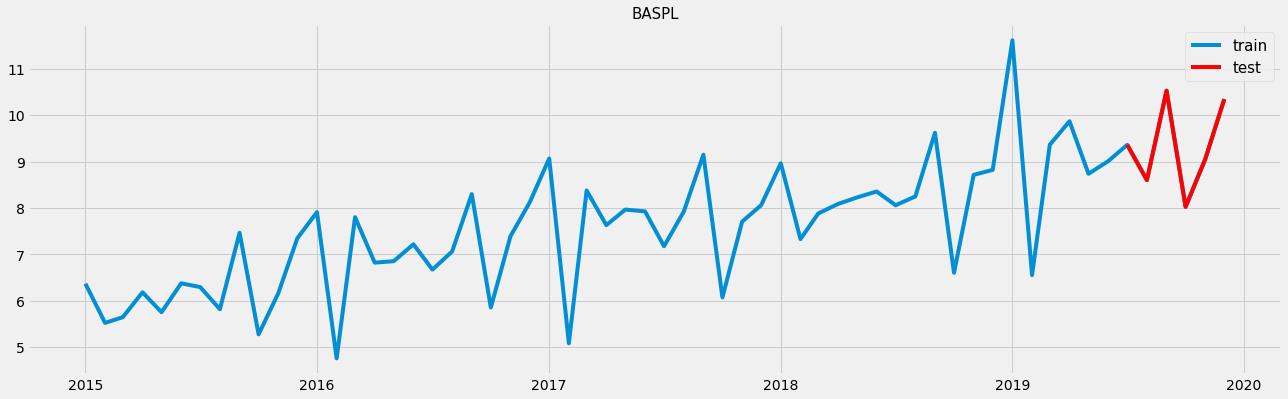

In [58]:
#展示一下看看
data=data[choose]
data=data/10000000#进行伪归一化
#构建训练集测试集
cut=6#取最后cut天为测试集
data=pd.Series(data.values,\
                             index=pd.DatetimeIndex(start='2015-01-01',end='2019-12-01',freq='MS'))
y=data[:-cut]
true=data[-cut:]
plt.figure(figsize=(20,6))  #创建图形
plt.plot(data)
plt.plot(true,color='red')
plt.legend(('train', 'test'),fontsize='15')
plt.title(choose,fontsize='15') #添加标题
#plt.grid()
plt.show()

In [59]:
#以下函数均为对模型进行检验所用到的  精简代码的作用
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
def output():
    #展示在训练集上的表现 
    draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
    draw.iloc[:,0].plot(figsize=(12,6))
    draw.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('real', 'predict'),fontsize='15')
    plt.title("Train Data",fontsize='30') #添加标题
    plt.show()
    #展示在测试集上的表现 
    draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
    draw.iloc[:,0].plot(figsize=(12,6))
    draw.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
    plt.title("Test Data",fontsize='30') #添加标题
    plt.show()
    #输出结果
    print('训练集上的MAE/MSE/MAPE/涨跌准确率')
    print(mean_absolute_error(y_train_predict, y_train))
    print(mean_squared_error(y_train_predict, y_train) )
    print(mape(y_train_predict, y_train) )
    print(up_down_accuracy(y_train_predict,y_train))
    print('测试集上的MAE/MSE/MAPE/涨跌准确率')
    print(mean_absolute_error(y_test_predict, y_test))
    print(mean_squared_error(y_test_predict, y_test) )
    print(mape(y_test_predict,  y_test) )
    print(up_down_accuracy(y_test_predict,y_test))

In [50]:
#优化，找到最小的AIC 从而得到sarima模型的参数ARIMA(p,d,q)(P,D,Q)s
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:367.99395176948445
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:290.9608884551019
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:118.22947393050022
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1140.742095363443
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:95.20393130853827
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:80.17251610248547
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:84.32423768451704
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:81.69358154199125
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:316.6857795862288
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:226.3000937573015
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:115.17022295584309
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1179.146316856514
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:91.60340590801913
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:89.53494432832274
ARIMA(0, 0, 1)x(1, 1, 0, 12)12

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2853      0.248     -1.153      0.249      -0.770       0.200
ma.L1         -1.0000    775.672     -0.001      0.999   -1521.290    1519.290
ar.S.L12      -0.6537      0.381     -1.714      0.087      -1.401       0.094
ma.S.L12      -0.3739      0.431     -0.867      0.386      -1.219       0.472
sigma2         0.2486    192.850      0.001      0.999    -377.730     378.227


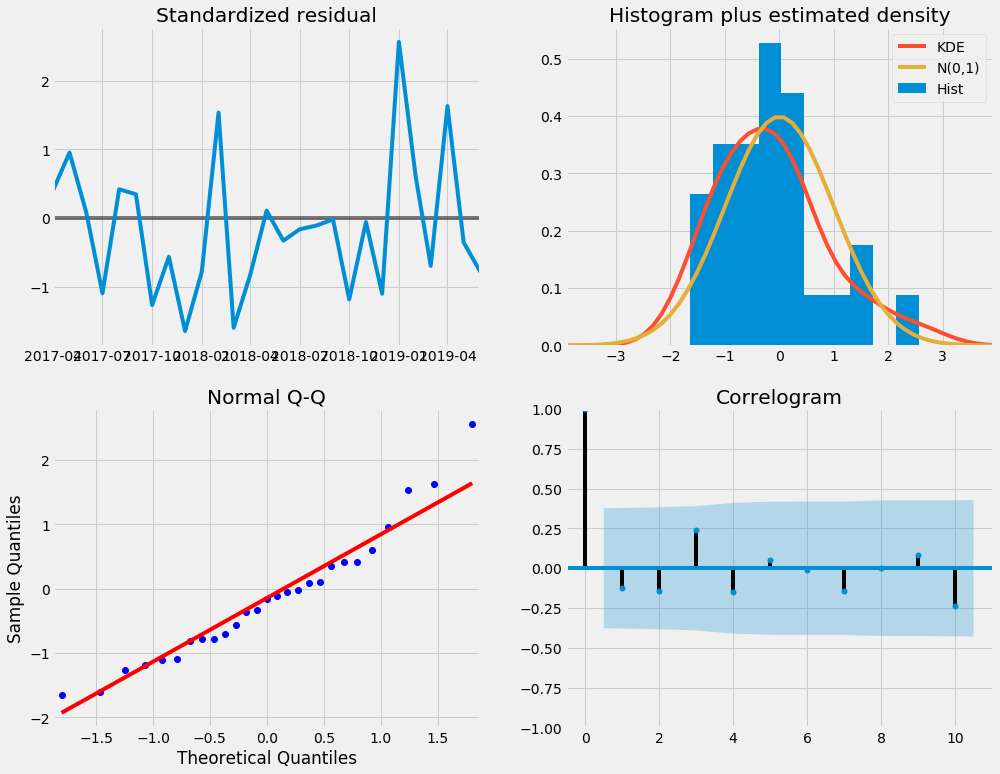

In [60]:
#SARIMA模型 
#拟合模型+检验模型 残差不能相关
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

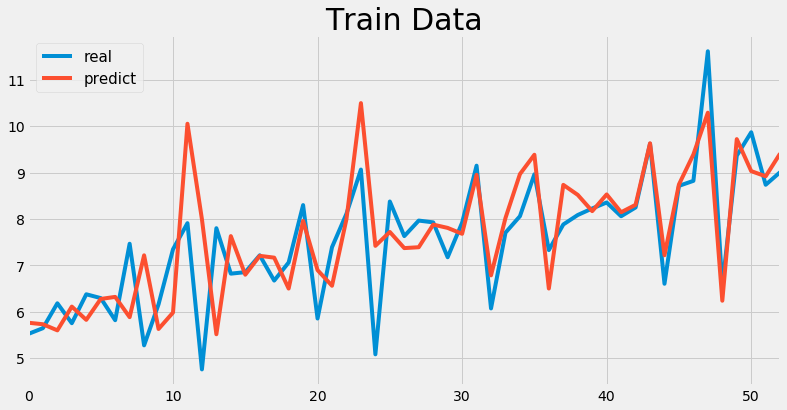

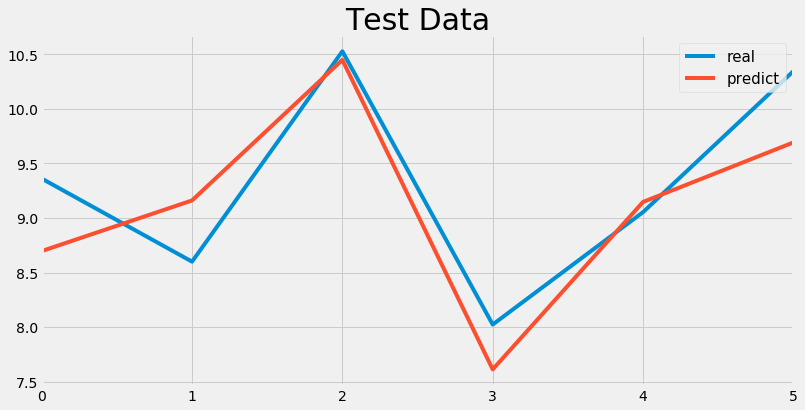

训练集上的MAE/MSE/MAPE/涨跌准确率
0.6709432633054327
0.9176201619984317
9.095112702622133
0.6346153846153846
测试集上的MAE/MSE/MAPE/涨跌准确率
0.4103445885025305
0.22783705149854447
4.613390985876368
0.8


In [62]:
#展示效果
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
y_train_predict = pred.predicted_mean.values
y_train = y.values
y_train_predict = y_train_predict[1:]
y_train = y_train[1:]
#在测试集上进行预测
pred_uc = results.get_forecast(steps=cut)  # retun out-of-sample forecast 
y_test_predict=pred_uc.predicted_mean
y_test_predict=y_test_predict.values
y_test=true.values
output()

In [63]:
#用来画残差图 直接调用即可
import statsmodels.tsa.api as smt
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

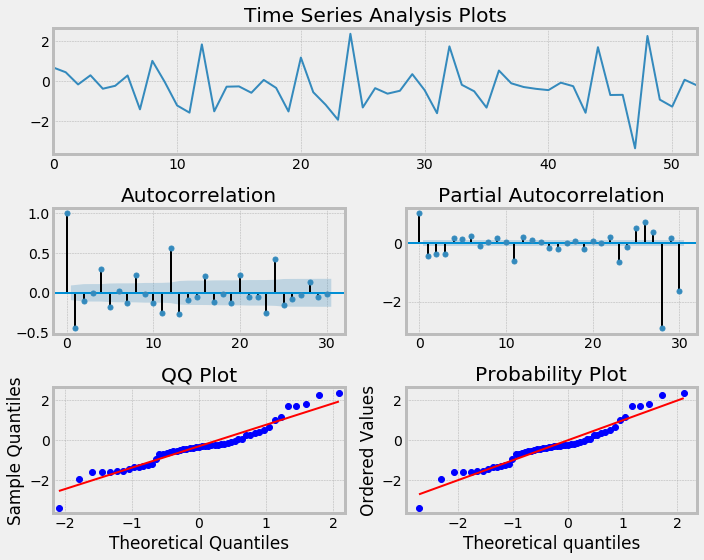

In [64]:
#滑动平均模型
#拟合模型+检验模型 残差不能相关
mod = sm.tsa.ExponentialSmoothing(y,seasonal_periods=12)
results = mod.fit()
#在训练集上进行预测
y_train_predict = results.predict(start=0,)
y_train = y.values
y_train_predict = y_train_predict[1:].values
y_train = y_train[1:]
#检验模型 残差不能相关
residual=y_train_predict-y_train
tsplot(residual, lags=30)

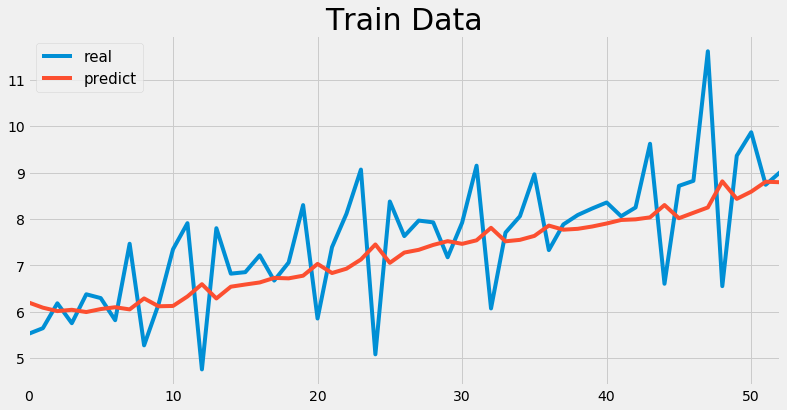

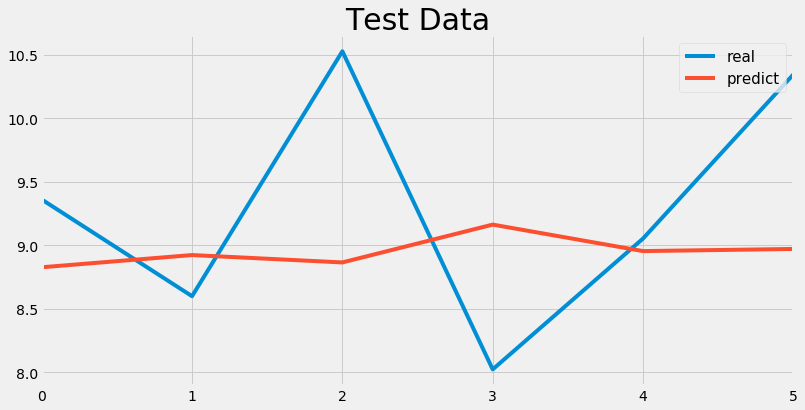

训练集上的MAE/MSE/MAPE/涨跌准确率
0.8540303042194232
1.2418639783212235
11.774602551182818
0.36538461538461536
测试集上的MAE/MSE/MAPE/涨跌准确率
0.8554286550404729
1.0583323544579215
9.547160573414798
0.2


In [65]:
#实际预测 只能滚动预测
predict=[]
for i in range(cut):
    y=data[:-i-1]#取多个数据集进行滚动预测
    mod = sm.tsa.ExponentialSmoothing(y,seasonal_periods=12)
    results = mod.fit()
    pred=results.predict()
    predict.append(float(pred))
predict.reverse()
#在测试集上进行预测
y_test_predict=predict
y_test_predict=np.array(y_test_predict)
y_test=true.values
#展示效果
output()